# Preprocessing Data

In [1]:
import os 

import geoplot as gplt
import holidays
us_holidays = holidays.UnitedStates()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import math
import datetime
import rtree
import sys

import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon, Point
from pyproj import CRS

from setup import *

%matplotlib inline

In [29]:
period = 'after'
# filter data records according to time period
if period == 'before':
    start_date = before_start_date
    end_date = before_end_date
else:
    start_date = after_start_date
    end_date = after_end_date

# 1. Create Catchment Areas
w.r.t. GTFS stops

In [3]:
catchment_area_radius_meters = 350

In [4]:
rail_stations = gpd.read_file(project_data_dir+'data_raw/CTA_Rail/CTA_RailStations.shp')

In [5]:
# Filter Downtown Stations
rail_stations = rail_stations.to_crs(CRS("epsg:4326"))
downtown = (-87.645168, 41.872034, -87.623921, 41.889749)
downtown_stations = rail_stations.cx[-87.645168:-87.62392, 41.872034:41.889749]
downtown_stations.to_csv(project_data_dir+"data_processed/downtown_stations.csv", index=False)

In [6]:
rail_stations = rail_stations.to_crs(CRS("epsg:26916"))

In [7]:
# GTFS should be station_id + 40000 but not entirely reliable
# using station_id as key instead
rail_catchment = rail_stations.copy()
rail_catchment['catchment'] = rail_catchment.geometry.buffer(catchment_area_radius_meters)
rail_catchment['catchment'] = rail_catchment.catchment.apply(Polygon)
del rail_catchment['geometry']
rail_catchment = rail_catchment.rename(columns={'catchment':'geometry'})
rail_catchment['catchment_area'] = rail_catchment['geometry'].map(lambda p: p.area)

In [8]:
rail_catchment.to_file(project_data_dir+'data_processed/shapefiles/py_rail_stations_catchment_'+str(catchment_area_radius_meters)+'.shp')

# 2. Rail Ridership

In [8]:
# match between ventra (ridership count) and rail lines
lookup = pd.read_csv(project_data_dir+"ventra_gtfs_match.csv")
rail_stations = pd.merge(rail_stations, lookup, left_on='STATION_ID', right_on='station_id')

In [30]:
d = pd.DataFrame()
df_iter = pd.read_csv(doe_data_dir+"raw_data/mobility/pt_aug19_oct20.csv", iterator=True, chunksize=1000000)
for df_chunk in df_iter:
    df_chunk['day'] = pd.to_datetime(df_chunk['day'])
    df_chunk = df_chunk[((df_chunk['day']>=start_date)&(df_chunk['day']<=end_date))]
    df_chunk['dow'] = df_chunk['dow'].str.strip()
    d = pd.concat((d, df_chunk), ignore_index=True)

print('Shape:', d.shape)
print('Columns:', d.columns.tolist())# d_points: the locations of transit stops/stations
d_points = d[['stop_name','mode','lat','lon']].drop_duplicates().dropna()
print('Number of stops/stations:', len(d_points))

Shape: (11599842, 9)
Columns: ['week', 'day', 'dow', 'quarter_hour', 'mode', 'stop_name', 'lat', 'lon', 'count']
Number of stops/stations: 10372


In [31]:
# edit the temporal dimension.
days = d.groupby('day').size().reset_index().iloc[:, :-1].reset_index()
days['holiday'] = [int(date in us_holidays) for date in days['day']]
days.to_csv(project_data_dir+period+"_dates.csv", index=False)
daydict = pd.Series(days.index.values,index=days.day).to_dict()

In [32]:
print(days.iloc[0]['day'], days.iloc[-1]['day'])

2020-04-01 00:00:00 2020-10-31 00:00:00


In [33]:
d['day_index'] = d['day'].map(daydict)
# create ts as quarter_hour index
d['ts'] = (d['day_index'])*24*4 + d['quarter_hour']
d.dropna(inplace=True)

In [14]:
# For some reason, this version has stop_ids missing, so matching using names
# check whether names match!!
# proceed if both lists are empty
ventra_names = d[d['mode']=='CTA Rail']['stop_name'].drop_duplicates()
gtfs_names = rail_stations['ventra_name']

print('In Ventra Counts not in Shape (GTFS)', ventra_names[~ventra_names.isin(gtfs_names)].tolist())
print('In Ventra Counts not in Shape (GTFS)', gtfs_names[~gtfs_names.isin(ventra_names)].tolist())

In Ventra Counts not in Shape (GTFS) []
In Ventra Counts not in Shape (GTFS) []


In [15]:
# create rail counts wrt quarters/stop (gtfs)
d_gtfs = d.merge(rail_stations, left_on=['stop_name'], right_on=['ventra_name'])
d_gtfs = d_gtfs.groupby(['ts','mode','station_id'], as_index=False).sum()[['ts','mode','station_id','count']]

In [52]:
rail_df = d_gtfs.loc[d_gtfs['mode']=='CTA Rail', ['ts','station_id','count']].sort_values(
    by=['ts','station_id']).reset_index(drop=True)

In [16]:
# save data
rail_df.to_csv(project_data_dir+'data_processed/rail_catchment/'+period+'/rail_df.csv', index=False)

In [53]:
# For visualization, average daily total for each station
rail_df['day_index']=rail_df['ts']//96
rail_df = rail_df.groupby(['day_index','station_id'], as_index=False).sum()
rail_df = rail_df.groupby('station_id', as_index=False).mean()

rail_df[['station_id', 'count']].to_csv(project_data_dir+"data_processed/viz/"+period+"_rail_avg_daily_total.csv", index=False)

# 3. Bus Ridership

In [16]:
bus_stops = d[d['mode']=='CTA Bus'][['stop_name','lat','lon']].drop_duplicates()
point_geom = [Point(xy) for xy in zip(bus_stops['lon'],bus_stops['lat'])]
bus_stops = gpd.GeoDataFrame(bus_stops, crs=CRS("epsg:4326"), geometry=point_geom)
bus_stops = bus_stops.to_crs(CRS("epsg:26916"))

In [55]:
bus_ridership = pd.merge(d[d['mode']=='CTA Bus'], bus_stops, on=['stop_name','lat','lon'])

# For visualization, average daily total for each station
bus_viz = bus_ridership.groupby(['day','stop_name', 'lat', 'lon'], as_index=False).sum()
bus_viz = bus_viz.groupby(['stop_name', 'lat', 'lon'], as_index=False).mean()[['stop_name', 'lat', 'lon', 'count']]
point_geom = [Point(xy) for xy in zip(bus_viz['lon'],bus_viz['lat'])]

bus_viz = gpd.GeoDataFrame(bus_viz, crs=CRS("epsg:4326"), geometry=point_geom)
bus_viz.to_file(project_data_dir+"data_processed/viz/"+period+"_bus_avg_daily_total.shp")

In [ ]:
bus_ridership = pd.merge(d[d['mode']=='CTA Bus'], bus_stops, on=['stop_name','lat','lon'])

In [19]:
bus_stops = gpd.sjoin(rail_catchment, bus_stops, how='inner',op='contains')\
            [['STATION_ID','stop_name','lat','lon','geometry']]

In [19]:
bus_rail_df = bus_ridership.groupby(['ts','STATION_ID'], as_index=False).sum()[['STATION_ID','ts','count']]
bus_rail_df.rename(columns={'count':'bus_count'}, inplace=True)

In [20]:
bus_rail_df.to_csv(data_dir+"data_processed/rail_catchment/"+period+"/bus_rail_df.csv", index=False)

# 4. TNC Ridership

TNC data's geometry identifier is census tracts.

### Create df to connect catchment areas to census blocks

In [18]:
# shapefile of census blocks 2010 
gblk = pd.read_csv(doe_data_dir+'raw_data/census/CensusBlockTIGER2010.csv')
# craete a geometric object
gblk['the_geom'] = gblk['the_geom'].apply(wkt.loads)
# create the geo dataframe
block_gdf = gpd.GeoDataFrame(gblk, geometry='the_geom')
# Calculate the area of the blocks/polygons
block_gdf.crs = CRS('epsg:4326')
block_gdf = block_gdf.to_crs("epsg:26916")

In [19]:
tract_gdf = block_gdf.dissolve(by=['STATEFP10','COUNTYFP10','TRACTCE10'], as_index=False)
tract_gdf['area'] = tract_gdf['the_geom'].map(lambda p: p.area)
tract_gdf['GEOID10'] = tract_gdf['GEOID10'].astype(str).str[:11]

In [20]:
## Combine the dataframes by getting the overlapping areas and computing the proportion of block area that falls
## within each stop's catchment area
## returns the geometry of df1
def shape_intersect(df1, df2):
    r = gpd.overlay(df1, df2, how='intersection')
    r['int_area'] = r['geometry'].to_crs({'proj': 'cea'}).map(lambda p: p.area)
    r['proportion_area_blk'] = r['int_area']/r['area']
    r['proportion_area_stop'] = r['int_area']/r['catchment_area']
    
    return r

In [21]:
### This takes a while 
# tract level: used to relate TNC data to transit stop catchment areas
# maps GEOID10 to the catchment areas of transit stops
tract_int_stop = shape_intersect(tract_gdf, rail_catchment)
tract_int_stop['proportion_area_tract'] = tract_int_stop['int_area']/tract_int_stop['area']
tract_int_stop['proportion_area_stop'] = tract_int_stop['int_area']/tract_int_stop['catchment_area']

In [34]:
tnc_files = [name[4:-4].split("_")+[name] for name in os.listdir(doe_data_dir+"processed_data/mobility/TNC") if name[:3]=='tnc']
tnc_files = pd.DataFrame(tnc_files, columns=['start_date','end_date','name'])
tnc_files['start_date'] = pd.to_datetime(tnc_files['start_date']).dt.date
tnc_files['end_date'] = pd.to_datetime(tnc_files['end_date']).dt.date
tnc_files.sort_values(by='start_date', inplace=True)

In [35]:
tnc = pd.DataFrame()
for s,e,name in zip(tnc_files['start_date'],tnc_files['end_date'],tnc_files['name']):        
    if (end_date >= s) | (start_date <= e):
        df_chunk = pd.read_csv(doe_data_dir+"processed_data/mobility/TNC/"+name)
        df_chunk['Trip Start Timestamp'] = pd.to_datetime(df_chunk['Trip Start Timestamp'])
        df_chunk = df_chunk.dropna(subset=['Pickup Census Tract'])
        if (end_date >= e) & (start_date <= s):
            print(name, 'all')
            tnc = tnc.append(df_chunk)
        else:
            print(name, 'part')
            tnc = tnc.append(df_chunk[(df_chunk['Trip Start Timestamp']>=start_date)&(df_chunk['Trip Start Timestamp']<=end_date)])


tnc_20190601_20190831.csv part
tnc_20190901_20190930.csv part
tnc_20191001_20191231.csv part
tnc_20200101_20200229.csv part
tnc_20200401_20200630.csv all
tnc_20200701_20200930.csv all


In [36]:
tnc['start_hour'] = tnc['Trip Start Timestamp'].dt.hour
tnc['start_min'] = tnc['Trip Start Timestamp'].dt.minute
tnc['interval_15'] = tnc['start_hour']*4 + tnc['start_min']//15
tnc['day_index'] = tnc['Trip Start Timestamp'].dt.date.map(daydict)
tnc['ts'] = tnc['day_index']*96 + tnc['interval_15']

tnc['Pickup Census Tract'] = tnc['Pickup Census Tract'].astype(int).astype(str)

In [59]:
# For visualization, average daily total for each station
tnc_viz = tnc.groupby(['day_index','Pickup Census Tract'], as_index=False).count()[['ts','Pickup Census Tract','Fare']]
tnc_viz.columns = ['day_index','Pickup Census Tract','trips']
tnc_viz = tnc_viz.groupby('Pickup Census Tract', as_index=False).mean()[['Pickup Census Tract','trips']]
tnc_viz.to_csv(project_data_dir+"data_processed/viz/"+period+"_tnc_avg_daily_total.csv", index=False)

In [37]:
tnc = tnc.groupby(['ts','Pickup Census Tract'], as_index=False).count()[['ts','Pickup Census Tract','Fare']]
tnc.columns = ['ts','Pickup Census Tract','trips']

In [38]:
# Merge data with dataframe that matches blocks to catchment areas
tnc_count_catchment = pd.merge(tnc, tract_int_stop[['GEOID10','STATION_ID','proportion_area_stop']], how = 'left', 
                          left_on = ['Pickup Census Tract'], right_on = 'GEOID10')

# Allocate trips from blocks to catchment areas
tnc_count_catchment['tnc_count'] = tnc_count_catchment['trips']*tnc_count_catchment['proportion_area_stop']

# Sum up for each quarter hour and cell
tnc_cell_count = tnc_count_catchment.groupby(['STATION_ID','ts'])['tnc_count'].sum().reset_index()

print(tnc_cell_count.columns.tolist())

['STATION_ID', 'ts', 'tnc_count']


In [39]:
tnc_cell_count.to_csv(project_data_dir+'data_processed/rail_catchment/'+period+'/tnc_rail_df.csv', index=False)

# 5. Spatial Only (Demographics,POI)
2018 demographic data's resolution is block groups


This block groups is different from the census tract 10 block groups!!

In [40]:
blkgrps = gpd.read_file(project_data_dir+'data_raw/tl_2018_17_bg/tl_2018_17_bg.shp')
blkgrps['COUNTYFP'] = blkgrps['COUNTYFP'].astype(int)
blkgrps['TRACTCE'] = blkgrps['TRACTCE'].astype(int)
blkgrps['BLKGRPCE'] = blkgrps['BLKGRPCE'].astype(int)

blkgrps = blkgrps.to_crs("epsg:26916")
blkgrps['area'] = blkgrps['geometry'].map(lambda p: p.area)

In [41]:
# block group level: used to relate demographics to the urban grid
block18_int_stop = shape_intersect(blkgrps, rail_catchment)

In [42]:
# demographic information of census blocks
demos = pd.read_csv(project_data_dir+'data_raw/nhgis0004_ds239_20185_2018_blck_grp.csv')
# merge demo and catchment areas
demo_catchment = pd.merge(demos, block18_int_stop[['COUNTYFP','TRACTCE','BLKGRPCE','GEOID',
                                                   'STATION_ID','proportion_area_stop']], 
                       how = 'left', left_on = ['COUNTYA', 'TRACTA','BLKGRPA'], 
                       right_on = ['COUNTYFP','TRACTCE','BLKGRPCE'])

data_cols = [x for x in list(demo_catchment.columns) if len(x) == 8 and x[0:2]=='AJ' and x[4]=='E']
# This will tell us if we have any non-numeic data types
# print(demo_to_grid[data_cols].dtypes.value_counts())
# Run this to find out which columns are non-numeric. Then can feed them to the next line
# demo_to_grid[data_cols].select_dtypes(include=['int64']).columns
data_cols.remove('AJ0EE001')

demo_prop = demo_catchment.copy().fillna(0)
# proportional demographics info
demo_prop[data_cols] = demo_prop[data_cols].multiply(demo_prop["proportion_area_stop"], axis="index")

In [43]:
travel_time_cols = ['AJXEE0'+str(i).zfill(2) for i in range(2,14)]
tt_medians = [2.5,7,12,17,22,27,32,37,42,52,74.5,100]

# aggregate values for each station.
demo_catchment = demo_prop.groupby('STATION_ID')[data_cols].sum().reset_index()

# create demographics for each cell.
demo_catchment['pct25_34yrs'] = (demo_catchment[['AJWBE011','AJWBE012',
                                         'AJWBE035','AJWBE036']].sum(axis = 1))/demo_catchment['AJWBE001']
demo_catchment['pct35_50yrs'] = (demo_catchment[['AJWBE013','AJWBE014','AJWBE015',
                                         'AJWBE037','AJWBE038','AJWBE039']].sum(axis = 1))/demo_catchment['AJWBE001']
demo_catchment['pctover65yrs'] = (demo_catchment[['AJWBE020','AJWBE021','AJWBE022','AJWBE023','AJWBE024','AJWBE025',
                                          'AJWBE044','AJWBE045','AJWBE046','AJWBE047','AJWBE048','AJWBE049']].sum(axis = 1))/demo_catchment['AJWBE001']
demo_catchment['pctwhite_alone'] = demo_catchment['AJWNE002']/demo_catchment['AJWNE001']
demo_catchment['pct_nonwhite'] = (demo_catchment['AJWNE001']-demo_catchment['AJWNE002'])/demo_catchment['AJWNE001']
demo_catchment['pctblack_alone'] = demo_catchment['AJWNE003']/demo_catchment['AJWNE001']
demo_catchment['pct_hs_grad'] = (demo_catchment[['AJYPE017','AJYPE018','AJYPE019','AJYPE020','AJYPE021','AJYPE022',
                                         'AJYPE023','AJYPE024','AJYPE025']].sum(axis = 1))/demo_catchment['AJYPE001']
demo_catchment['pct_col_grad'] = (demo_catchment[['AJYPE022','AJYPE023','AJYPE024','AJYPE025']].sum(axis = 1))/demo_catchment['AJYPE001']
demo_catchment['pctPTcommute'] = demo_catchment['AJXCE010']/demo_catchment['AJXCE001']

demo_catchment['25_34yrs'] = (demo_catchment[['AJWBE011','AJWBE012',
                                         'AJWBE035','AJWBE036']].sum(axis = 1))
demo_catchment['35_50yrs'] = (demo_catchment[['AJWBE013','AJWBE014','AJWBE015',
                                         'AJWBE037','AJWBE038','AJWBE039']].sum(axis = 1))
demo_catchment['over65yrs'] = (demo_catchment[['AJWBE020','AJWBE021','AJWBE022','AJWBE023','AJWBE024','AJWBE025',
                                          'AJWBE044','AJWBE045','AJWBE046','AJWBE047','AJWBE048','AJWBE049']].sum(axis = 1))
demo_catchment['white_alone'] = demo_catchment['AJWNE002']/demo_catchment['AJWNE001']
demo_catchment['nonwhite'] = demo_catchment['AJWNE001']-demo_catchment['AJWNE002']
demo_catchment['black_alone'] = demo_catchment['AJWNE003']
demo_catchment['hs_grad'] = (demo_catchment[['AJYPE017','AJYPE018','AJYPE019','AJYPE020','AJYPE021','AJYPE022',
                                         'AJYPE023','AJYPE024','AJYPE025']].sum(axis = 1))
demo_catchment['col_grad'] = (demo_catchment[['AJYPE022','AJYPE023','AJYPE024','AJYPE025']].sum(axis = 1))
demo_catchment['PTcommute'] = demo_catchment['AJXCE010']

demo_catchment['avg_tt_to_work'] = (demo_catchment[travel_time_cols].multiply(tt_medians, axis = 1).sum(axis =1))/demo_catchment['AJXEE001']

# create income info
# demo_catchment['pct60plusmincommute'] = (demo_catchment[['AJXEE012','AJXEE013']].sum(axis=1))/demo_catchment['AJXEE001']
cell_inc = demo_prop.groupby('STATION_ID').apply(lambda x: 
                    (x['AJWME001']*x['AJ0EE001']).sum(axis = 0)/x['AJWME001'].sum(axis=0)).reset_index()
cell_inc.columns = ['STATION_ID','inc_per_capita']
demo_catchment = pd.merge(demo_catchment, cell_inc, how = 'left', on = 'STATION_ID')

/home/jtl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in double_scalars


In [74]:
# extract demo data
demo_df = demo_catchment[['STATION_ID','AJWME001',
                       'pct25_34yrs','pct35_50yrs','pctover65yrs',
                       'pctwhite_alone','pct_nonwhite','pctblack_alone',
                       'pct_col_grad','pctPTcommute',
                       '25_34yrs','35_50yrs','over65yrs',
                       'white_alone','nonwhite','black_alone',
                       'col_grad','PTcommute',
                       'avg_tt_to_work','inc_per_capita']].fillna(0)

demo_df = demo_df.rename(columns = {'AJWME001':'tot_population'})

demos = ['tot_population','pct25_34yrs','pct35_50yrs','pctover65yrs',
         'pctwhite_alone','pct_nonwhite','pctblack_alone',
         'pct_col_grad','pctPTcommute','25_34yrs','35_50yrs','over65yrs',
         'white_alone','nonwhite','black_alone',
         'col_grad','PTcommute','avg_tt_to_work','inc_per_capita']

In [75]:
# job
jobs = pd.read_csv(project_data_dir+'data_raw/il_wac_S000_JT00_2017.csv', usecols = [0,1])
jobs.columns = ['GEOID10','jobs']
jobs['GEOID10'] = jobs['GEOID10'].astype(str).str[:12]
jobs = jobs.groupby('GEOID10', as_index=False).sum()

jstation = block18_int_stop.merge(jobs, how = 'inner', left_on = 'GEOID', right_on='GEOID10')
jstation['jobs'] = jstation['proportion_area_stop'].astype(float)*jstation['jobs'].astype(int)
jstation = jstation.groupby(['STATION_ID'])['jobs'].sum().reset_index()

demo_df = pd.merge(demo_df, jstation, on='STATION_ID')

In [79]:
poi = gpd.read_file(project_data_dir+'data_raw/POI_OSM/gis_osm_pois_free_1.shp')

non_attractions = ['water_tower','toilet','post_box','pitch','drinking_water','atm','comms_tower','prison',
                   'recycling','camera_surveillance','windmill','bench','waste_basket','water_well','telephone',
                  'vending_machine','recycling_metal','wastewater_plant','reclycling_glass','chemist',
                  'recycling_paper','wayside_cross','recycling_clothes']

### Use category data from Patrick
poi_cat = pd.read_csv(project_data_dir+'data_raw/POIcat.csv')

poi_cat.columns = ['fclass','cat','start_active_time','end_active_time']

poi_map = pd.Series(poi_cat.cat.values,index=poi_cat.fclass).to_dict()

poi['category'] = poi['fclass'].map(poi_map).fillna('other')

### further aggregate
cat2 = {'bar':'restaurant','entertainment':'entertainment', 'hotel':'entertainment', 
        'public attraction':'entertainment', 'restaurant':'restaurant',
        'school':'school', 'services':'shop', 'shop':'shop'}
poi['category_2'] = poi['category'].map(cat2)
poi.dropna(inplace=True)

categories = list(poi['category_2'].unique())

poi = poi[~poi['fclass'].isin(non_attractions)]
poi.crs = CRS('epsg:4326')
poi = poi.to_crs("epsg:26916")

poi_grid = gpd.sjoin(poi, rail_catchment, how="inner", op='intersects')
p = poi_grid.groupby(['STATION_ID','category_2']).size().unstack().reset_index().fillna(0)
p['all'] = p[categories].sum(axis = 1)

In [80]:
# save
spatial_df = pd.merge(demo_df, p, on='STATION_ID')
spatial_df.to_csv(project_data_dir+"data_processed/rail_catchment/spatial.csv", index=False)

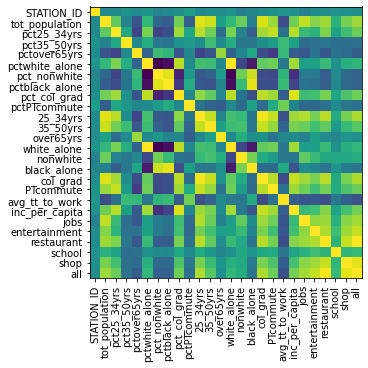

In [96]:
# correlation between spatial variables
fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(spatial_df.corr().to_numpy())
ax.set_yticks(np.arange(len(spatial_df.columns)))
ax.set_yticklabels(spatial_df.columns.tolist());
ax.set_xticks(np.arange(len(spatial_df.columns)))
ax.set_xticklabels(spatial_df.columns.tolist(), rotation=90);

# 6. Temporal Only (Weather - Daily)

In [39]:
weather = pd.read_csv(project_data_dir+'data_raw/weather.csv', parse_dates = ['DATE'])
weather = weather[weather['NAME']=='CHICAGO OHARE INTERNATIONAL AIRPORT, IL US']

weather.fillna(0, inplace=True)
weather.sort_values(by = 'DATE', inplace=True)
weather = weather[(weather['DATE']>=start_date)&(weather['DATE']<=end_date)]

weather['week'] = weather.DATE.dt.isocalendar().week
weather['year'] = weather.DATE.dt.isocalendar().year
weather['TAVGAVG'] = weather.groupby(['week','year']).transform(np.mean)['TAVG']

weather['PRCP'] = weather['PRCP'] + weather['SNOW']

weather['DAY_INDEX'] = weather['DATE'].map(daydict)
weather[['DATE','DAY_INDEX','PRCP','TAVGAVG','TAVG']].to_csv(project_data_dir+'data_processed/weather_'+period+'.csv', index=False)


# 7. Level of Service: Rail Frequency

In [8]:
# Get GFTS Versions
gtfs_versions = [name.split("-") for name in os.listdir(project_data_dir+"data_raw/CTA_GTFS")]
gtfs_versions = pd.DataFrame(gtfs_versions, columns=['start_date','end_date'])
gtfs_versions['start_date'] = pd.to_datetime(gtfs_versions['start_date']).dt.date
gtfs_versions['end_date'] = pd.to_datetime(gtfs_versions['end_date']).dt.date
gtfs_versions = gtfs_versions.sort_values('end_date', ascending=False).reset_index(drop=True)

In [9]:
gtfs_versions

,start_date,end_date
0,2020-09-01,2020-12-30
1,2020-08-15,2020-10-31
2,2020-07-27,2020-09-30
3,2020-06-12,2020-08-31
4,2020-04-16,2020-06-30
5,2020-03-02,2020-05-31
6,2020-02-19,2020-04-30
7,2019-12-19,2020-02-29
8,2019-10-04,2019-12-31
9,2019-09-03,2019-11-30


In [50]:
def get_counts_from_gtfs(path, cur_date):
    
    path = project_data_dir + "data_raw/CTA_GTFS/"+folder
    s = pd.read_csv(path+'/stops.txt', dtype={'trip_id':str})
    r = pd.read_csv(path+'/routes.txt') 
    t = pd.read_csv(path+'/trips.txt', dtype={'service_id':str, 'trip_id':str, 'shape_id':str, 'schd_trip_id':str})
    st = pd.read_csv(path+'/stop_times.txt', dtype={'trip_id':str})
    c = pd.read_csv(path+'/calendar.txt', dtype={'service_id':str, 'start_date':str, 'end_date':str})
    cd = pd.read_csv(path+'/calendar_dates.txt', dtype={'service_id':str, 'date':str})

    c['start_date'] = pd.to_datetime(c['start_date'])
    c['end_date'] = pd.to_datetime(c['end_date'])
    cd['date'] = pd.to_datetime(cd['date'])

    # get service_ids from calendar.txt
    dow_col = cur_date.day_name().lower()
    service_ids = c[(c[dow_col] == 1) & (c['start_date']<=cur_date) & (c['end_date']>=cur_date)]['service_id']

    # modify according to calendar_dates.txt
    service_ids = service_ids.append(cd[(cd['date']==cur_date) & (cd['exception_type']==1)]['service_id'])
    service_ids = service_ids[~service_ids.isin(cd[(cd['date']==cur_date) & (cd['exception_type']==2)]['service_id'])]

    # get ids of scheduled trips from trips.txt
    schd_trips = t[t['service_id'].isin(service_ids.tolist())]

    # filter down to rail stations
    # stops.parent_station corresponds to the gtfs code in lookup file
    # stop_id is NOT station id!
    s = s[s['parent_station'].isin(rail_stations['gtfs'])]
    r = r[r['route_type']==1]

    # count stop times for identified trips and stations
    stt = st.merge(s, on='stop_id')
    stt = stt.merge(schd_trips, how = 'inner', on = 'trip_id')
    stt = stt.merge(r, how = 'inner', on = 'route_id')
    stt['arrival_time'] = stt['arrival_time'].astype(str)
    stt['arrival_hour'] = stt['arrival_time'].str[:2].astype(int)
    stt['arrival_min'] = stt['arrival_time'].str[3:5].astype(int)
    stt['interval_15'] = stt['arrival_hour'] * 4 + stt['arrival_min']//15
    stt['ts'] = ts_day_base + stt['interval_15']

    # 
    counts = stt.groupby(['ts','parent_station'], as_index=False).count()[['ts','parent_station','trip_id']]
    
    return counts

In [51]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + datetime.timedelta(n)

ts_day_base = 0
rail_freq = pd.DataFrame(columns = ['ts','parent_station','trip_id'])    
for cur_date in daterange(start_date, end_date):
    day_index = daydict[cur_date]
    ver = gtfs_versions[(cur_date >= gtfs_versions['start_date']) & (cur_date <= gtfs_versions['end_date'])]
    print(cur_date, end='\t')
    if len(ver)==0:
        ts_day_base += 96
        print(cur_date, 'not found!')
        continue
    else:
        folder = datetime.datetime.strftime(gtfs_versions['start_date'].iloc[ver.index[0]],"%Y%m%d") + '-' + \
                datetime.datetime.strftime(gtfs_versions['end_date'].iloc[ver.index[0]],"%Y%m%d")
        new = get_counts_from_gtfs(folder, cur_date)
        new['day_index'] = day_index
        rail_freq = rail_freq.append(new)
        ts_day_base += 96

2020-04-01 00:00:00	13025
2020-04-02 00:00:00	13025
2020-04-03 00:00:00	13025
2020-04-04 00:00:00	12832
2020-04-05 00:00:00	12651
2020-04-06 00:00:00	13008
2020-04-07 00:00:00	13025
2020-04-08 00:00:00	13025
2020-04-09 00:00:00	13025
2020-04-10 00:00:00	13025
2020-04-11 00:00:00	12832
2020-04-12 00:00:00	12651
2020-04-13 00:00:00	13008
2020-04-14 00:00:00	13025
2020-04-15 00:00:00	13025
2020-04-16 00:00:00	13025
2020-04-17 00:00:00	13025
2020-04-18 00:00:00	12832
2020-04-19 00:00:00	12651
2020-04-20 00:00:00	13008
2020-04-21 00:00:00	13025
2020-04-22 00:00:00	13025
2020-04-23 00:00:00	13025
2020-04-24 00:00:00	13025
2020-04-25 00:00:00	12832
2020-04-26 00:00:00	12651
2020-04-27 00:00:00	13008
2020-04-28 00:00:00	13025
2020-04-29 00:00:00	13025
2020-04-30 00:00:00	13025
2020-05-01 00:00:00	13025
2020-05-02 00:00:00	12832
2020-05-03 00:00:00	12651
2020-05-04 00:00:00	13008
2020-05-05 00:00:00	13025
2020-05-06 00:00:00	13025
2020-05-07 00:00:00	13025
2020-05-08 00:00:00	13025
2020-05-09 0

In [52]:
# translate parent station (gtfs) into station_id in ventra
rail_freq.columns = ['ts', 'parent_station', 'num_schd_trp_15min','day_index']
rail_freq = rail_freq.merge(rail_stations, left_on='parent_station', right_on='gtfs')

rail_freq = rail_freq[['station_id','ts','num_schd_trp_15min','day_index']]

In [53]:
rail_freq.to_csv(project_data_dir+'data_processed/rail_catchment/'+period+'/rail_count_df.csv', index=False)